# Import thư viện

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Load dữ liệu

In [38]:
df = pd.read_csv("../etl/datasets/movie_features.csv")


# Chuẩn bị X (loại nhãn), y (nhãn thật để đánh giá)

In [39]:
feature_cols = ['avg_rating', 'rating_count', 'rating_std', 'year']

X = df[feature_cols].values
y = df['label_genre'].values

# Chuẩn hoá dữ liệu

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Thực hiện Clustering

# KMeans

In [41]:
n_clusters = len(np.unique(y))
km = KMeans(n_clusters=n_clusters, random_state=42)
labels_km = km.fit_predict(X_scaled)

# DBSCAN (tinh chỉnh eps, min_samples)


In [42]:
db = DBSCAN(eps=0.5, min_samples=5)
labels_db = db.fit_predict(X_scaled)

# Mã hóa nhãn

In [43]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Đánh giá kết quả

In [44]:
def safe_f1(true, pred):
    """Tính F1 nếu có thể (nếu nhãn dự đoán đủ điều kiện)."""
    valid = (pred >= 0)
    if np.sum(valid) == 0:
        return np.nan
    return f1_score(true[valid], pred[valid], average='macro')

results = {
    'model': ['KMeans', 'DBSCAN'],
    'ARI': [
        adjusted_rand_score(y_encoded, labels_km),
        adjusted_rand_score(y_encoded, labels_db)
    ],
    'NMI': [
        normalized_mutual_info_score(y_encoded, labels_km),
        normalized_mutual_info_score(y_encoded, labels_db)
    ],
    'F1_macro': [
        safe_f1(y_encoded, labels_km),
        safe_f1(y_encoded, labels_db)
    ]
}
df_report = pd.DataFrame(results)
print(df_report)

    model       ARI      NMI  F1_macro
0  KMeans  0.009802  0.03931  0.034213
1  DBSCAN  0.006702  0.01325  0.028974


# Lưu kết quả ra CSV

In [45]:
output_path = "../etl/reports/cluster_evaluation.csv"
df_report.to_csv(output_path, index=False)
print(f"✅ Kết quả đã lưu tại: {output_path}")

✅ Kết quả đã lưu tại: ../etl/reports/cluster_evaluation.csv


# Trực quan hoá 2D

# Biểu đồ phân tán

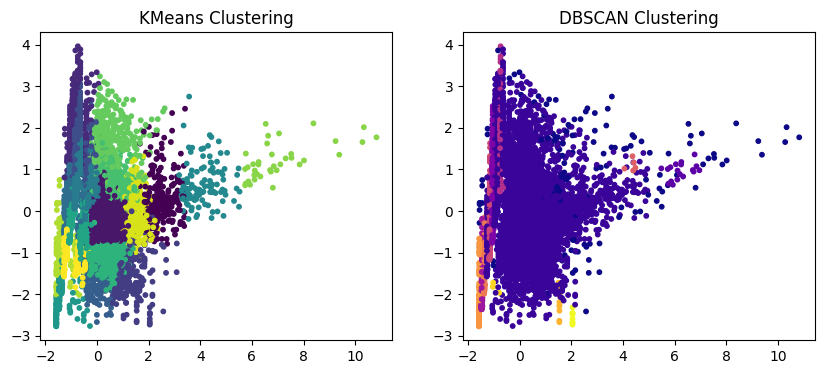

In [46]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_km, cmap='viridis', s=10)
ax[0].set_title("KMeans Clustering")

ax[1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_db, cmap='plasma', s=10)
ax[1].set_title("DBSCAN Clustering")
plt.show()

# Biểu đồ cột


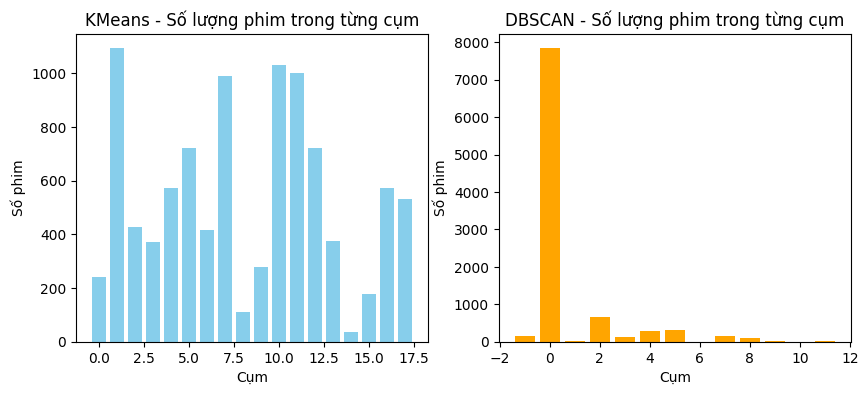

In [47]:
unique_km, counts_km = np.unique(labels_km, return_counts=True)
unique_db, counts_db = np.unique(labels_db, return_counts=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(unique_km, counts_km, color='skyblue')
ax[0].set_title("KMeans - Số lượng phim trong từng cụm")
ax[0].set_xlabel("Cụm")
ax[0].set_ylabel("Số phim")

ax[1].bar(unique_db, counts_db, color='orange')
ax[1].set_title("DBSCAN - Số lượng phim trong từng cụm")
ax[1].set_xlabel("Cụm")
ax[1].set_ylabel("Số phim")

plt.show()